In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [2]:
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

# 1. Train model on MNIST dataset

In [3]:
MNIST_IMAGE_SIZE = 28

num_input_channels = 1
num_output_classes = 10

num_conv1_channels = 32
conv_kernel_size = 3
conv_stride = 1
conv_padding = 1
pool_kernel_size = 2
num_conv2_channels = 64

fc1_output_size = 128

dropout_rate = 0.25

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_input_channels,
            out_channels=num_conv1_channels,
            kernel_size=conv_kernel_size,
            stride=conv_stride,
            padding=conv_padding,
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_conv1_channels,
            out_channels=num_conv2_channels,
            kernel_size=conv_kernel_size,
            stride=conv_stride,
            padding=conv_padding,
        )
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=pool_kernel_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(
            num_conv2_channels * MNIST_IMAGE_SIZE**2 // pool_kernel_size**4,
            fc1_output_size,
        )
        self.fc2 = nn.Linear(fc1_output_size, num_output_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
MNIST_MEAN, MNIST_STD = (0.1307,), (0.3081,)
BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(MNIST_MEAN, MNIST_STD)]
)
mnist_training_data = datasets.MNIST(root='datasets/', train=True, transform=transform, download=True)
mnist_test_data = datasets.MNIST(root='datasets/', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=mnist_training_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=mnist_test_data, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
learning_rate = 1e-6

my_dummy_model = CNN()
optimizer = optim.Adam(my_dummy_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [6]:
writer = SummaryWriter()

In [7]:
BATCH_TO_PRINT = 100
NUM_EPOCHS = 1

def train_model(data_loader, network, optimizer, criterion, num_epochs=NUM_EPOCHS):
    network = network.to(device)
    network.train()
    for epoch in range(num_epochs):
        running_loss = epoch_loss = 0.
        for i, data in enumerate(data_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()

            if i % BATCH_TO_PRINT == (BATCH_TO_PRINT - 1):
                print('[Epoch %d, Batch %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / BATCH_TO_PRINT))
                running_loss = 0.0

        writer.add_scalar(f'Loss/train:', epoch_loss / len(data_loader), epoch)
        print(f"[{epoch + 1}] loss: {epoch_loss / len(data_loader):.3f}")

    writer.flush()
    return network


def test_model(data_loader, network):
    network = network.to(device)
    network.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(F'Test accuracy: {(100 * correct / total):.2f}%')

In [8]:
trained_dummy_network = train_model(train_loader, my_dummy_model, optimizer, loss_function)

[Epoch 1, Batch   100] loss: 2.306
[Epoch 1, Batch   200] loss: 2.291
[Epoch 1, Batch   300] loss: 2.276
[Epoch 1, Batch   400] loss: 2.260
[Epoch 1, Batch   500] loss: 2.250
[Epoch 1, Batch   600] loss: 2.232
[Epoch 1, Batch   700] loss: 2.216
[Epoch 1, Batch   800] loss: 2.198
[Epoch 1, Batch   900] loss: 2.183
[1] loss: 2.243


In [9]:
DUMMY_MODEL_NAME = 'my-cnn-mnist-1-epoch.pt'

In [10]:
torch.save(trained_dummy_network.state_dict(), DUMMY_MODEL_NAME)

In [11]:
trained_dummy_network = CNN()
trained_dummy_network.load_state_dict(torch.load(DUMMY_MODEL_NAME))

<All keys matched successfully>

In [12]:
test_model(test_loader, trained_dummy_network)

Test accuracy: 47.71%


# Train the model with a higher learning rate

In [13]:
learning_rate = 1e-3

my_model = CNN()
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)
trained_network = train_model(train_loader, my_model, optimizer, loss_function, num_epochs=15)

[Epoch 1, Batch   100] loss: 0.600
[Epoch 1, Batch   200] loss: 0.179
[Epoch 1, Batch   300] loss: 0.117
[Epoch 1, Batch   400] loss: 0.110
[Epoch 1, Batch   500] loss: 0.106
[Epoch 1, Batch   600] loss: 0.080
[Epoch 1, Batch   700] loss: 0.090
[Epoch 1, Batch   800] loss: 0.071
[Epoch 1, Batch   900] loss: 0.071
[1] loss: 0.154
[Epoch 2, Batch   100] loss: 0.055
[Epoch 2, Batch   200] loss: 0.044
[Epoch 2, Batch   300] loss: 0.065
[Epoch 2, Batch   400] loss: 0.053
[Epoch 2, Batch   500] loss: 0.053
[Epoch 2, Batch   600] loss: 0.054
[Epoch 2, Batch   700] loss: 0.055
[Epoch 2, Batch   800] loss: 0.051
[Epoch 2, Batch   900] loss: 0.054
[2] loss: 0.053
[Epoch 3, Batch   100] loss: 0.039
[Epoch 3, Batch   200] loss: 0.038
[Epoch 3, Batch   300] loss: 0.043
[Epoch 3, Batch   400] loss: 0.033
[Epoch 3, Batch   500] loss: 0.041
[Epoch 3, Batch   600] loss: 0.042
[Epoch 3, Batch   700] loss: 0.043
[Epoch 3, Batch   800] loss: 0.037
[Epoch 3, Batch   900] loss: 0.035
[3] loss: 0.039
[Epoch 

In [14]:
SECOND_MODEL_FILENAME = 'my-cnn-mnist-lr1e-3-15-epoch.pt'
torch.save(trained_network.state_dict(), SECOND_MODEL_FILENAME)

In [15]:
test_model(test_loader, trained_network)

Test accuracy: 99.33%


# Applying t-SNE and PCA

In [16]:
class CNNForFeatureExtraction(CNN):
    def forward(self, x):
        # Without fully-connected layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = torch.flatten(x, start_dim=1)
        return x

In [17]:
feature_extractor = CNNForFeatureExtraction()

## Untrained model

In [18]:
feature_extractor.load_state_dict(torch.load(DUMMY_MODEL_NAME))

<All keys matched successfully>

In [19]:
def extract_features(feature_extractor, test_loader):
    features = []
    true_labels = []
    for images, labels in test_loader:
        with torch.no_grad():
            x = feature_extractor(images)
            features.append(x.flatten(start_dim=1))
            true_labels.append(labels)

    features = torch.cat(features, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    return features, true_labels

In [20]:
features, true_labels = extract_features(feature_extractor, test_loader)

### t-SNE

In [21]:
features_embedded = TSNE(n_components=2).fit_transform(features)

In [22]:
def plot_t_sne(tsne_result, true_labels):
    sns.scatterplot(
        x=tsne_result[:, 0],
        y=tsne_result[:, 1],
        hue=true_labels,
        palette=sns.hls_palette(10),
        legend='full',
    )
    plt.title('t-SNE Plot')
    plt.show()

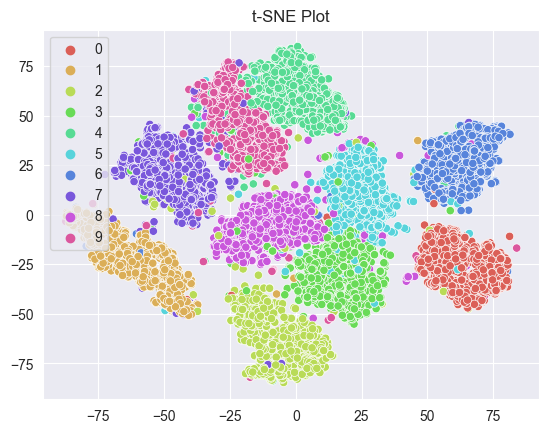

In [23]:
plot_t_sne(features_embedded, true_labels)

### PCA

In [24]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

In [25]:
def plot_pca(pca_result, true_labels):
    sns.scatterplot(
        x=pca_result[:, 0],
        y=pca_result[:, 1],
        hue=true_labels,
        palette=sns.hls_palette(10),
        legend='full',
    )
    plt.title('PCA Plot')
    plt.show()

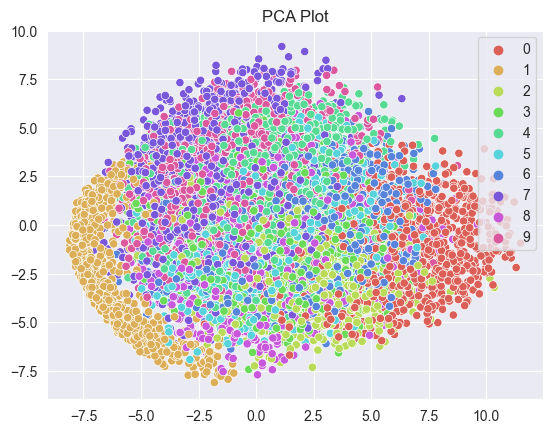

In [26]:
plot_pca(pca_result, true_labels)

## Trained model

In [27]:
feature_extractor.load_state_dict(torch.load(SECOND_MODEL_FILENAME))

<All keys matched successfully>

In [28]:
features, true_labels = extract_features(feature_extractor, test_loader)

### t-SNE

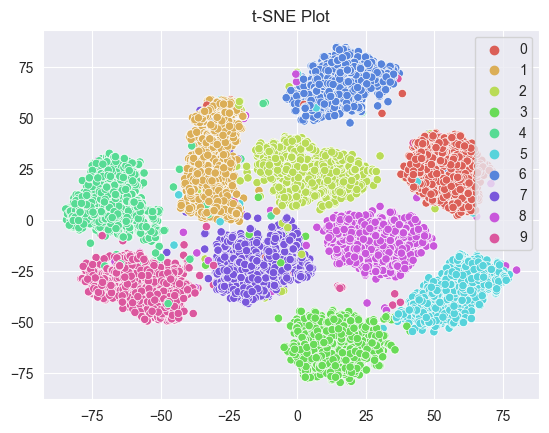

In [29]:
features_embedded = TSNE(n_components=2).fit_transform(features)
plot_t_sne(features_embedded, true_labels)

### PCA

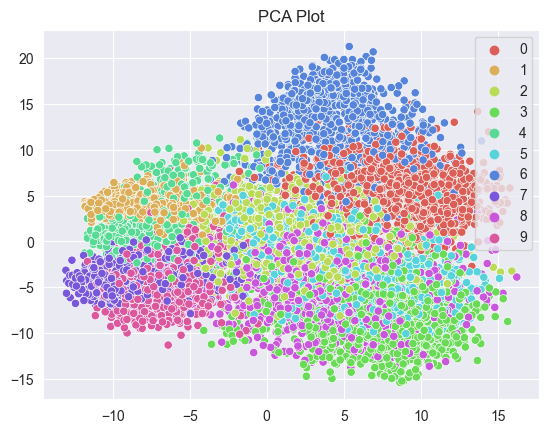

In [30]:
pca_result = PCA(n_components=2).fit_transform(features)
plot_pca(pca_result, true_labels)